# Gassian Prediction Subgoal Stability

This notebook will analyze the stability of subgoal distributions when updated online.

The input data will be from `simulator/dyn_sg_list.pkl`.

In [56]:
%matplotlib notebook
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import mat4py
import math
import pickle

mpl.style.use('mitch-exp')

## Load data from log

In [57]:
pwd

u'/Users/mitchallain/Development/Python/BeagleBone-excavator/jupyter/CDC'

In [85]:
filename = 'dyn_sgs_0314_1919'
with open('../../simulator/pickles/' + filename + '.pkl', 'rb') as openfile:
    sgs = pickle.load(openfile)

num = len(sgs)
k, m = sgs[0][0].shape

all_means = np.zeros((num, k, m))
all_covs = np.zeros((num, k, m, m))

for i, (means, covs) in enumerate(sgs):
    all_means[i] = means
    all_covs[i] = covs

In [87]:
sgs[0][0][5], sgs[-1][0][5]

(array([ 10.07696176,   5.23745956,   4.11574401,   1.35589317]),
 array([ 10.0118958 ,   5.0877383 ,   4.00694995,   1.4039447 ]))

# Convert to end-effector space

Convert all measurements to end-effector space for later use.

In [88]:
def forward_kin_v(exc, sw, bm, sk, bk, bias=0):
    '''This func is the same as 'forward_kin' in this module but is easily vectorized.

    Note: ported to Python from MATLAB "fwd_kin.m", assumed options = [0, 0]

    Args:
        exc (dict): a dict of the excavator physical parameters
        sw (float): the swing angle
        bm (float): boom displacement in cm
        sk      ^^
        bk      ^^
        bias (float): positive z bias on output, to adjust weird base frame

    Returns:
        eef (list: float): the position of the end-effector (EEF) in (x, y, z - base frame) and the angle of the bucket (axis x4 w.r.t. x1(0?) ground axis)
    '''
    # Assign the base swing angle
    t1 = sw

    # Define lengths
    a1 = exc['a1']
    a2 = exc['a2']
    a3 = exc['a3']
    a4 = exc['a4']

    # Compute or Get joint angles
    # Boom angle
    r_c1 = bm + exc['r_cyl1']
    a_a1b = np.arccos((exc['r_o1b']**2 + exc['r_o1a']**2 - r_c1**2)/(2 * exc['r_o1b']*exc['r_o1a']))
    t2 = a_a1b - exc['a_b12'] - exc['a_a1x1']

    # Stick angle
    r_c2 = sk + exc['r_cyl2']
    a_c2d = np.arccos((exc['r_o2c']**2 + exc['r_o2d']**2 - r_c2**2)/(2 * exc['r_o2c'] * exc['r_o2d']))
    t3 = 3 * np.pi - exc['a_12c'] - a_c2d - exc['a_d23']

    # Bucket angle
    r_c3 = bk + exc['r_cyl3']
    a_efh = np.arccos((exc['r_ef']**2 + exc['r_fh']**2 - r_c3**2)/(2 * exc['r_ef'] * exc['r_fh']))
    a_hf3 = np.pi - exc['a_dfe'] - a_efh
    r_o3h = math.sqrt(exc['r_o3f']**2 + exc['r_fh']**2 - 2 * exc['r_o3f'] * exc['r_fh'] * np.cos(a_hf3))
    a_f3h = np.arccos((r_o3h**2 + exc['r_o3f']**2 - exc['r_fh']**2)/(2 * r_o3h * exc['r_o3f']))
    a_h3g = np.arccos((r_o3h**2 + exc['r_o3g']**2 - exc['r_gh']**2)/(2 * r_o3h * exc['r_o3g']))
    t4 = 3 * np.pi - a_f3h - a_h3g - exc['a_g34'] - exc['a_23d']

    c1 = np.cos(t1)
    c2 = np.cos(t2)
    c234 = np.cos(t2 + t3 + t4)
    c23 = np.cos(t2 + t3)
    s1 = np.sin(t1)
    s2 = np.sin(t2)
    s234 = np.sin(t2 + t3 + t4)
    s23 = np.sin(t2 + t3)

    P04 = np.array([[c1*(a4*c234+a3*c23+a2*c2+a1)],
                    [s1*(a4*c234+a3*c23+a2*c2+a1)],
                    [(a4*s234+a3*s23+a2*s2)],
                    [1]])

    # Bucket angle; angle between x4 and x0-y0 plane
    tb = t2 + t3 + t4 - 3 * np.pi

    # Position and orientation of the end effector
    eef = [axis.pop() for axis in P04[0:3].tolist()]
    assert eef
    eef.append(tb)

    return eef[0], eef[1], eef[2] + bias

In [89]:
forward_kin = np.vectorize(forward_kin_v)
exc = mat4py.loadmat('exc.mat')['exc']

In [90]:
all_means[0, :, 3]

array([ 1.41983374, -0.001683  ,  1.39989041,  1.41983374, -0.01736938,
        1.35589317])

In [91]:
all_means_xyz = np.zeros((num, k, 3))

for i in range(num):
    all_means_xyz[i] = np.array(forward_kin(exc, all_means[i, :, 3], all_means[i, :, 0],
                              all_means[i, :, 1], all_means[i, :, 2], bias=17.1)).T

In [92]:
all_means_xyz[0, :, 0]

array([  6.45213999,  58.5594938 ,  11.63510341,   5.99319455,
        41.5722802 ,  14.36353622])

## Plot the first and last subgoals

Plot the first and last subgoal means.

In [93]:
set3 = plt.get_cmap('Set3').colors
alt = ['b', 'g', 'r', 'c', 'm', 'orange', 'grey']

In [94]:
from mpl_toolkits.mplot3d import Axes3D

In [95]:
def orient_plot(ax):
    ax.set_xlim3d([-20, 80])
    ax.set_ylim3d([0, 80])
    ax.set_zlim3d([0, 50])
    ax.view_init(azim=-142, elev=21)

<IPython.core.display.Javascript object>


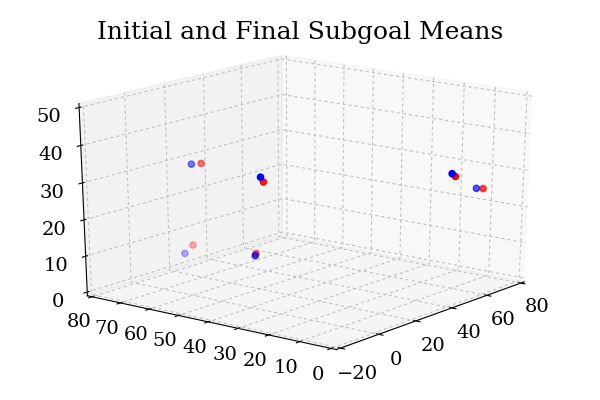

In [96]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(all_means_xyz[0, :, 0], all_means_xyz[0, :, 1], 
           all_means_xyz[0, :, 2], zdir='z', c='r')

ax.scatter(all_means_xyz[-1, :, 0], all_means_xyz[-1, :, 1], 
           all_means_xyz[-1, :, 2], zdir='z', c='b')

plt.title('Initial and Final Subgoal Means')
orient_plot(ax)
plt.tight_layout()

plt.savefig('figs/' + filename + '.pdf', dpi=600)

___